In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

D:\python\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
df = pd.read_excel('data/laporan_iklim_harian.xlsx')
df.head()

,NamaStasiun,WMOID,Tanggal,SuhuMinimum(°C),SuhuMaksimum(°C),SuhuRata-rata(°C),KelembabanRata-rata(%),CurahHujan(mm),LamaPenyinaran(jam),Kecepata AnginRata-rata(knot),ArahAnginTerbanyak(deg),KecepatanAnginTerbesar(knot),ArahAnginSaatKecepatanMaksimum(deg)
0,Stasiun Meteorologi Sultan Mahmud Badaruddin II,96221,2014-01-01,24.2,28.4,26.3,89,1.3,0.6,8,NW,8,315
1,Stasiun Meteorologi Sultan Mahmud Badaruddin II,96221,2014-01-02,24.1,30.4,26.6,88,0.0,1.8,8,N,8,315
2,Stasiun Meteorologi Sultan Mahmud Badaruddin II,96221,2014-01-03,23.3,30.6,26.5,88,1.2,1.0,7,NW,7,315
3,Stasiun Meteorologi Sultan Mahmud Badaruddin II,96221,2014-01-04,23.0,31.4,26.9,85,1.8,0.0,8,NW,8,270
4,Stasiun Meteorologi Sultan Mahmud Badaruddin II,96221,2014-01-05,23.0,31.0,26.2,84,3.1,1.2,8,NW,8,315


In [3]:
df.drop(['Tanggal', 'NamaStasiun ', 'WMOID'], axis=1, inplace=True)

In [4]:
df.head()

,SuhuMinimum(°C),SuhuMaksimum(°C),SuhuRata-rata(°C),KelembabanRata-rata(%),CurahHujan(mm),LamaPenyinaran(jam),Kecepata AnginRata-rata(knot),ArahAnginTerbanyak(deg),KecepatanAnginTerbesar(knot),ArahAnginSaatKecepatanMaksimum(deg)
0,24.2,28.4,26.3,89,1.3,0.6,8,NW,8,315
1,24.1,30.4,26.6,88,0.0,1.8,8,N,8,315
2,23.3,30.6,26.5,88,1.2,1.0,7,NW,7,315
3,23.0,31.4,26.9,85,1.8,0.0,8,NW,8,270
4,23.0,31.0,26.2,84,3.1,1.2,8,NW,8,315


In [5]:
df.dtypes

SuhuMinimum(°C)                        float64
SuhuMaksimum(°C)                       float64
SuhuRata-rata(°C)                      float64
KelembabanRata-rata(%)                   int64
CurahHujan(mm)                         float64
LamaPenyinaran(jam)                    float64
Kecepata AnginRata-rata(knot)            int64
ArahAnginTerbanyak(deg)                 object
KecepatanAnginTerbesar(knot)             int64
ArahAnginSaatKecepatanMaksimum(deg)      int64
dtype: object

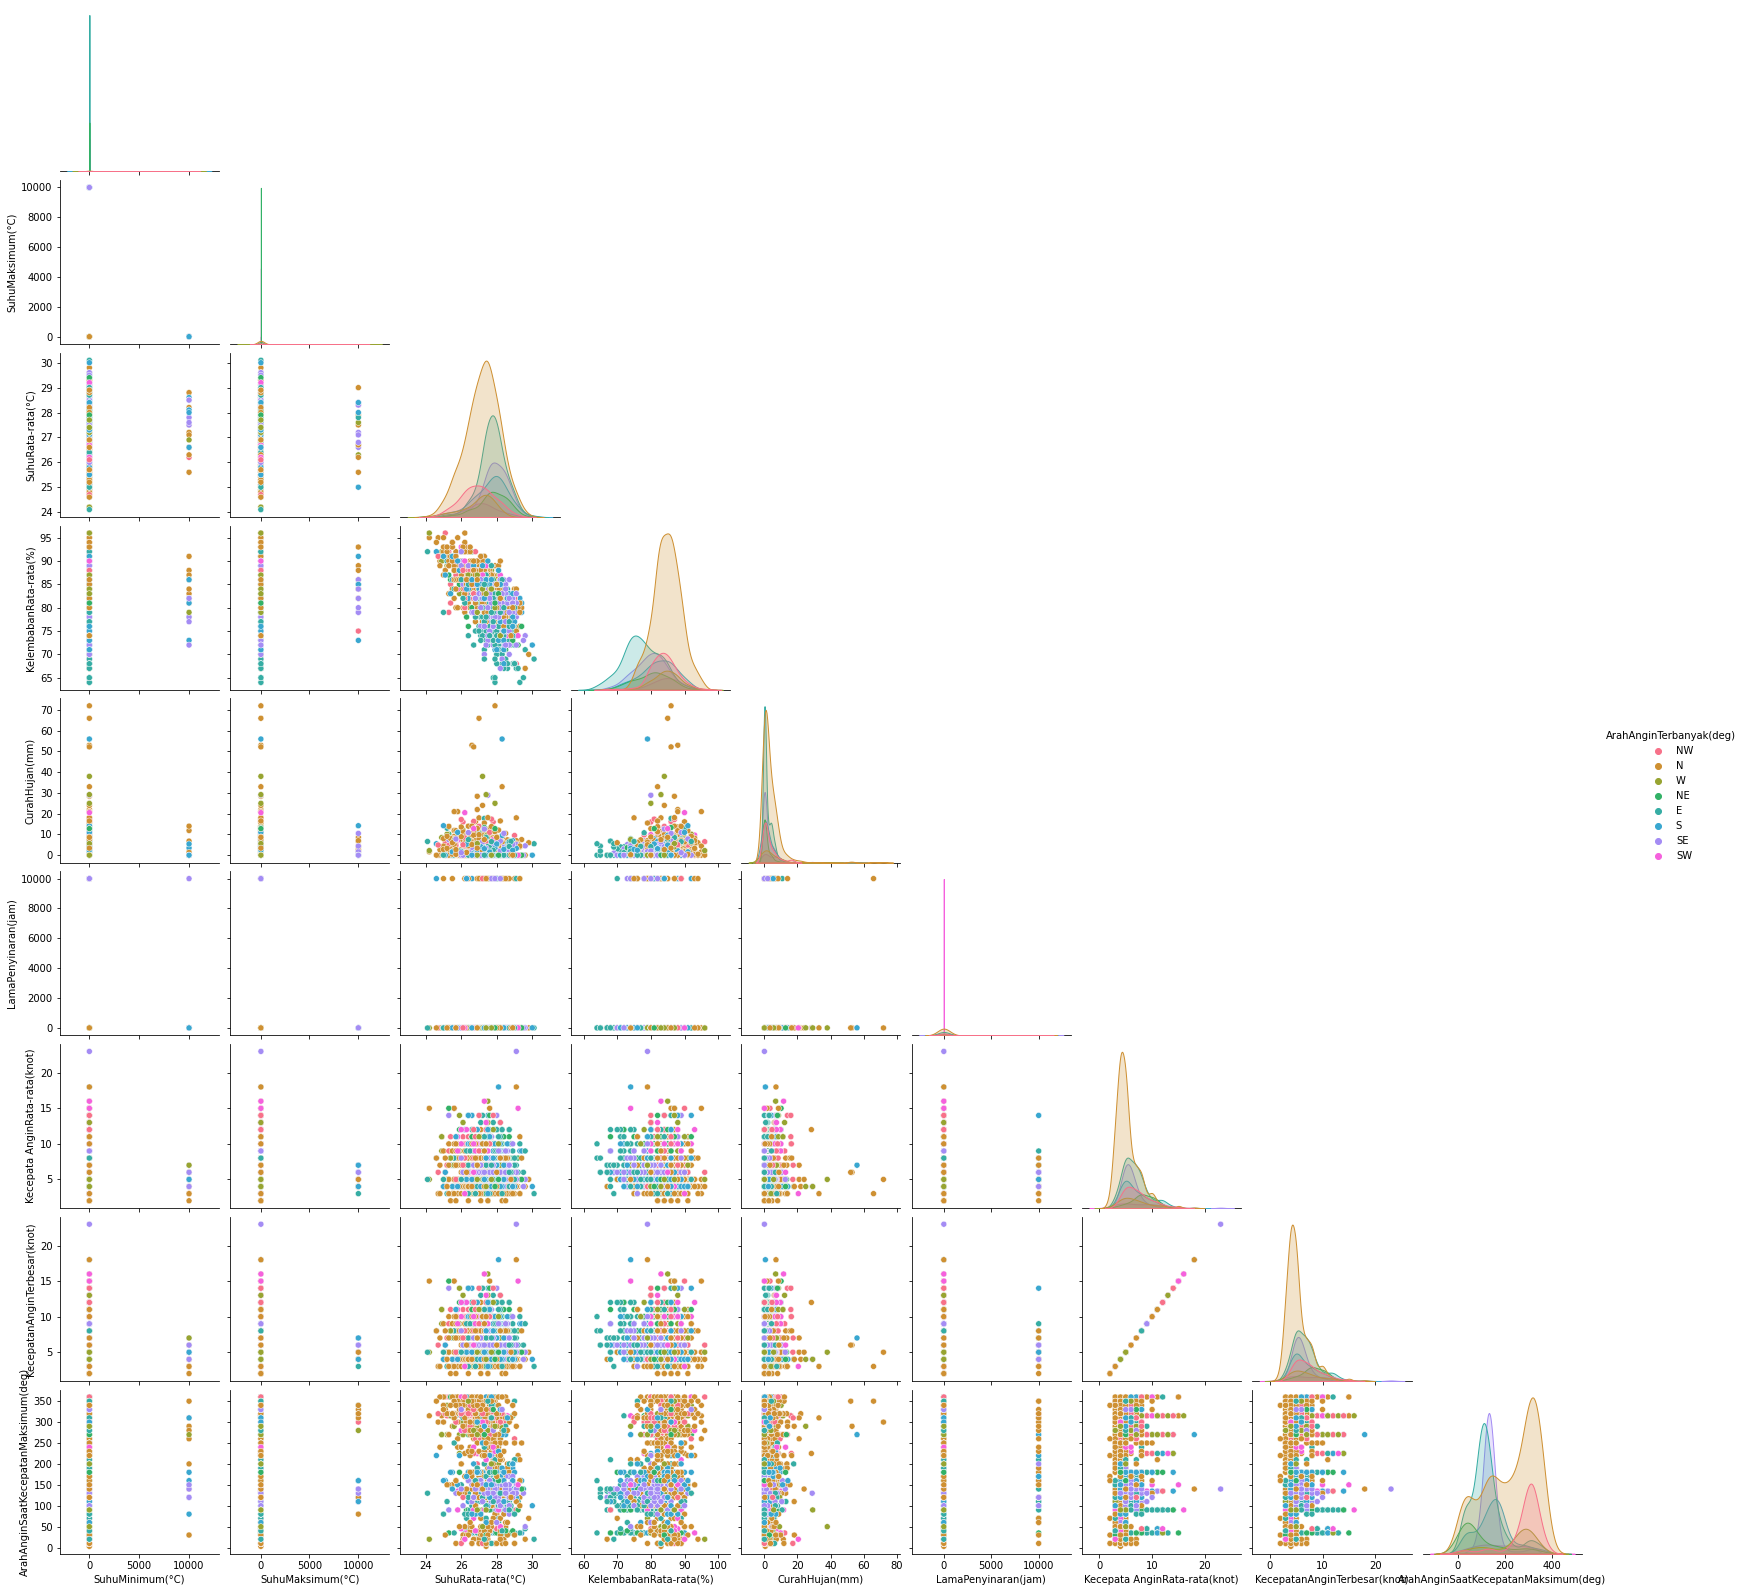

In [6]:
sns.pairplot(data= df, hue='ArahAnginTerbanyak(deg)', palette='husl', corner=True)

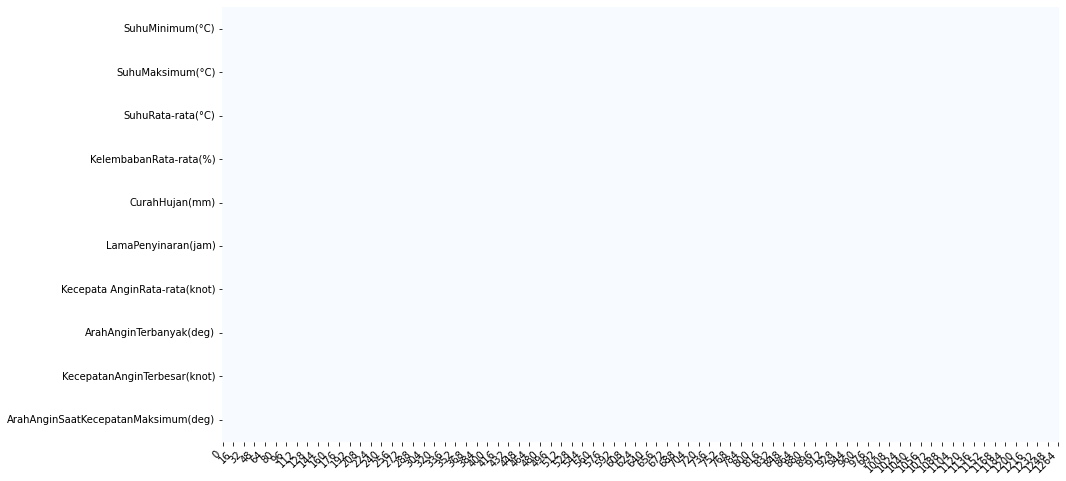

In [7]:
plot_missing_value(df)

In [8]:
df.corr()

,SuhuMinimum(°C),SuhuMaksimum(°C),SuhuRata-rata(°C),KelembabanRata-rata(%),CurahHujan(mm),LamaPenyinaran(jam),Kecepata AnginRata-rata(knot),KecepatanAnginTerbesar(knot),ArahAnginSaatKecepatanMaksimum(deg)
SuhuMinimum(°C),1.000000,-0.016041,0.009872,-0.007417,-0.012262,0.006348,-0.072585,-0.072585,-0.002213
SuhuMaksimum(°C),-0.016041,1.000000,-0.017952,0.033233,0.013305,-0.025901,-0.062442,-0.062442,0.017403
SuhuRata-rata(°C),0.009872,-0.017952,1.000000,-0.646673,-0.136910,0.019604,-0.063548,-0.063548,-0.340670
KelembabanRata-rata(%),-0.007417,0.033233,-0.646673,1.000000,0.175943,-0.039478,-0.114750,-0.114750,0.347153
CurahHujan(mm),-0.012262,0.013305,-0.136910,0.175943,1.000000,0.035303,-0.029654,-0.029654,0.112342
LamaPenyinaran(jam),0.006348,-0.025901,0.019604,-0.039478,0.035303,1.000000,-0.084595,-0.084595,-0.015908
Kecepata AnginRata-rata(knot),-0.072585,-0.062442,-0.063548,-0.114750,-0.029654,-0.084595,1.000000,1.000000,-0.029902
KecepatanAnginTerbesar(knot),-0.072585,-0.062442,-0.063548,-0.114750,-0.029654,-0.084595,1.000000,1.000000,-0.029902
ArahAnginSaatKecepatanMaksimum(deg),-0.002213,0.017403,-0.340670,0.347153,0.112342,-0.015908,-0.029902,-0.029902,1.000000


In [10]:
from sklearn.preprocessing import StandardScaler
SC = StandardScaler()
SC.get_feature_names_out(df)

array([[24.2, 28.4, 26.3, ..., 'NW', 8, 315],
       [24.1, 30.4, 26.6, ..., 'N ', 8, 315],
       [23.3, 30.6, 26.5, ..., 'NW', 7, 315],
       ...,
       [24.0, 32.1, 26.9, ..., 'W ', 5, 90],
       [23.5, 32.6, 27.4, ..., 'W ', 4, 90],
       [24.4, 31.8, 26.9, ..., 'N ', 7, 150]], dtype=object)